In [ ]:
#from analysis.features import get_seq, extract_features
from analysis.analyzer import SongAnalyzer
import matplotlib.pyplot as plt

In [42]:
import math
from typing import Iterable, Iterator
from collections import deque

SPACING = 0.5
SUPPORT_RADIUS = 1.5 * SPACING
def _kernel(x):
    x = (x / SPACING) + 1.5
    if x <= 1:
        y = x * x / 2
    elif x <= 2:
        y = (2 - x) * (x - 1) + 0.5
    else:
        x = x - 3
        y = x * x / 2
    return y / SPACING

def get_seq(note_times: Iterable[float]) -> Iterator[float]:
    note_times = iter(note_times)
    queue = deque()
    # raises StopIteration if note_times is empty, which is desired
    first = next(note_times, None)
    if first is None:
        return
    sample_loc = math.ceil((first - SUPPORT_RADIUS) / SPACING) * SPACING
    queue.append(first)
    while queue:
        lbound = sample_loc - SUPPORT_RADIUS
        rbound = sample_loc + SUPPORT_RADIUS
        # add new notes, ensuring last note in queue is beyond the
        # window, if possible
        if queue[-1] < rbound:
            next_note = next(note_times, None)
            while next_note is not None and next_note < rbound:
                queue.append(next_note)
                next_note = next(note_times, None)
            if next_note is not None:
                queue.append(next_note)
        # clear old notes
        while queue and queue[0] < lbound:
            queue.popleft()

        accum = 0
        for time in queue:
            if time < rbound:
                accum += _kernel(sample_loc - time)
        yield accum
        sample_loc += SPACING

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
def extract_features(seq: list[float]):
    max_nps = max(seq)
    length = len(seq)
    cum_nps_per_bin = [0 for _ in THRESHOLDS]
    count_per_bin = [0 for _ in THRESHOLDS]
    # num of samples where NPS > the threshold (fraction of max NPS)
    threshold_counts = [0 for _ in THRESHOLDS]
    segs_per_thresh = [[] for _ in THRESHOLDS]
    for nps in seq:
        for thresh_i, thresh in enumerate(THRESHOLDS):
            segs = segs_per_thresh[thresh_i]
            if nps > thresh * max_nps:
                threshold_counts[thresh_i] += 1
                if not segs or segs[-1] < 0: # if prev was break, start a new seg
                    segs.append(0)
                segs[-1] += 1
            else:
                if not segs or segs[-1] > 0: # if prev was a block, start a new seg
                    segs.append(0)
                segs[-1] -= 1
        bin_i = -1
        for thresh in THRESHOLDS:
            if nps > thresh * max_nps:
                bin_i += 1
            else:
                break
        if bin_i > -1:
            cum_nps_per_bin[bin_i] += nps
            count_per_bin[bin_i] += 1
    
    default_avg_nps = [x * max_nps for x in (0.1, 0.3, 0.5, 0.7, 0.9)]
    avg_nps_per_bin = [
        (cum_nps / count if count > 0 else default)
        for cum_nps, count, default in zip(cum_nps_per_bin, count_per_bin, default_avg_nps)
    ]

    density_per_bin = []
    for segs, count in zip(segs_per_thresh, threshold_counts):
        total_len = length
        if segs:
            if segs[0] < 0:
                total_len += segs[0]
            if len(segs) > 1 and segs[-1] < 0:
                total_len += segs[-1]
            density_per_bin.append(count / total_len)
        else:
            density_per_bin.append(0)


    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[0 for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    for thresh_i, thresh in enumerate(THRESHOLDS):
        segs = segs_per_thresh[thresh_i]
        for break_i, break_len in enumerate(BREAK_LENGTHS):
            cur_block = 0
            longest_block = 0
            for seg in segs:
                assert seg != 0
                if seg > 0: # is block
                    cur_block += seg
                elif -seg > break_len: # is break
                    # end block
                    longest_block = max(longest_block, cur_block)
                    cur_block = 0
            longest_block = max(longest_block, cur_block)
            longest_blocks[thresh_i][break_i] = longest_block

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin,
        *(math.log2(x+1) for row in longest_blocks for x in row)
    ]

In [47]:
import simfile
import numpy as np

def analyze(path, diff='challenge'):
    sim = simfile.open(path, strict=False)
    song_analyzer = SongAnalyzer(sim)
    chart_analyzer = song_analyzer.chart_analyzers[('dance-single', diff)]
    note_times = chart_analyzer.get_note_times()
    seq = list(get_seq(note_times))
    features = extract_features(seq)
    return seq, features

seq, features = analyze('packs/_misc/0320bfd0-dccb-4f2b-9ada-75295f5b0383_140BPM_Stamina_Killer.sm')

max_nps: 9.50778881633048 (142.6168322449572 bpm)
length: 28622 (14.80488726958397)
THRESHS:
[0.0, 1.901557763266096, 3.803115526532192, 5.704673289798288, 7.606231053064384]
avg nps per bin:
[0.17694587755340208, 2.054501632653062, 5.377181306130721, 6.655452171431336, 9.333300418309584]
([2.654188163301031, 30.817524489795932, 80.65771959196081, 99.83178257147004, 139.99950627464375])
length above thresh:
[28621, 28620, 28619, 28618, 28618]
([14.804836865355092, 14.804786459365154, 14.80473605161403, 14.804685642101598, 14.804685642101598])
density per bin:
[1.0, 1.0, 1.0, 1.0, 1.0]


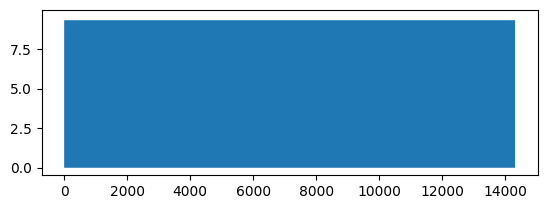

In [48]:
def to_bpm(nps):
    return nps*60/4

def print_features(f):
    print(f'max_nps: {f[0]} ({to_bpm(f[0])} bpm)')
    print(f'length: {round(2**f[1]-1)} ({f[1]})')
    print(f'THRESHS:\n{[t*f[0] for t in THRESHOLDS]}')
    print(f'avg nps per bin:\n{f[2:7]}\n({[to_bpm(nps) for nps in f[2:7]]})')
    print(f'length above thresh:\n{[round(2**x-1) for x in f[7:12]]}\n({f[7:12]})')
    print(f'density per bin:\n{f[12:17]}')
    
print_features(features)
fig = plt.figure()
ax = fig.add_subplot()
ax.fill_between(np.arange(0, len(seq)/2, 0.5), seq)
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*1/3)

plt.show()

In [9]:
14*60/4

210.0